# Build the news sentiments dataset

In [11]:
try:
    import alpha_vantage
except:
    ! pip install alpha_vantage
    import alpha_vantage

import requests
from pprint import pprint
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import json
import time
from tqdm import tqdm
import calendar
import os
sns.set()
pd.set_option('display.max_colwidth',1000)

In [12]:
def get_sentiments(company_symbol: str = '', news_topic: str = '', time_from: str = '', time_to: str = '', sort_by: str = 'RELEVANCE'):
    keys = ['API_KEY', 'YOUR_API_KEY', '9XZQZQZQZQZQZQZQ', 'TQ82I6FBRGST0SWG', 'NG88F4E3M06AUO7C', 'BVLIQRCET4I22OM8', '55AYQEHU4F19W8YS', '2AUO2G9N2BT4FMT6']
    # API KEY: NG88F4E3M06AUO7C
    # API KEY: BVLIQRCET4I22OM8
    # API KEY: 55AYQEHU4F19W8YS
    endpoint = "https://www.alphavantage.co/query"
    for key in keys:
        parameters = {
            "function": "NEWS_SENTIMENT",
            "sort": sort_by,
            "limit": "200",
            "apikey": key,
        }
        if time_from and time_to: parameters['time_from'] = time_from; parameters['time_to'] = time_to
        if news_topic: parameters['topics'] = news_topic
        if company_symbol: parameters['tickers'] = company_symbol
        # Send a GET request to the API endpoint
        response = requests.get(endpoint, params=parameters)
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            if 'Note' in data: 
                print(f'{key} api overuse')
                continue
            return data
        else: print(response)

# pprint(get_sentiments())

### Download all news sentiments from the past 100 days
Create a dataframe of the sentiments grouped by ticker symbols and sorted by time

Note that the sentiment score values indicate:
* Bearish: x <= -0.35
* Somewhat-Bearish: -0.35 < x <= -0.15
* Neutral: -0.15 < x < 0.15
* Somewhat_Bullish: 0.15 <= x < 0.35 
* Bullish: x >= 0.35


Note that another value maintained is the relevance score indicating the relevance of each article to the ticker 0 < x <= 1, with a higher score indicating higher relevance. However, this value is ignored for now. 

## <span style="color:red">TODO Once youre set on the type of data you want to collect, make the sweep only take data it doesnt already have - meaning only new daily news</span>

In [ ]:
def sweep_news_in_range(start_time: datetime):
    # todo make this more concise
    # create a dir called sentiments if it doesn't exist
    if not os.path.exists('sentiments'): os.mkdir('sentiments')
    sentiment_list = []
    # get the news up to 100 days ago. and every 5 iterations of action, sleep for one second\n",
    for i in tqdm(range(20)):
        # repeat the process for ealiest and latest
        for sort_by in ['LATEST', 'EARLIEST']:
            for j in range(5):
                time_to = (start_time - timedelta(days=i*5+j)).strftime('%Y%m%dT%H%M')
                time_from = (start_time - timedelta(days=i*5+j+1)).strftime('%Y%m%dT%H%M')
                # get the news sentiment for the past week
                sentiment = get_sentiments(news_topic='financial_markets', time_from=time_from, time_to=time_to, sort_by=sort_by)
                if not sentiment: return sentiment_list
                    # temporarily save the sentiments to a json file in a folder called sentiments
                with open(os.path.join('sentiments', f'sentiments{time_from}.json'), 'w') as f:
                    json.dump(sentiment, f, indent=4)
                # append the sentiment to the list
                sentiment_list.append(sentiment)
            time.sleep(60)
    return sentiment_list
    
# start sweeping from right now, for older sweeps change datetime to datetime.now() - timedelta(days=num_days_past)
all_news = sweep_news_in_range(datetime.now())

Parse out all necessary data from the raw jsons to create an ordered csv dataset

In [ ]:
ordered_sentiments = []
for news in tqdm(all_news):
    # temp addition
    if 'Note' in news: continue
    for article in news['feed']:
        # parse date time from YYYYMMDDTHHMM format to datetime object
        time_pub = datetime.strptime(article['time_published'], '%Y%m%dT%H%M%S')
        ordered_sentiments.append({'ticker': None, 'sentiment': article['overall_sentiment_score'], 'time': time_pub, 'url': article['url']})
        for tickers_sents in article['ticker_sentiment']:
            ordered_sentiments.append({'ticker': tickers_sents['ticker'], 'sentiment': tickers_sents['ticker_sentiment_score'], 'time': time_pub, 'url': article['url']})

# create a dataframe from the list of dictionaries
# remove duplicates caused by the same article being published on multiple websites or downloading multiple times using the sort_by
sent_df = pd.DataFrame(ordered_sentiments).drop_duplicates(keep='last').sort_values(by='time', ascending=False).set_index('ticker')
start_time, end_time = sent_df.iloc[0]['time'].strftime('%d_%m_%Y'), sent_df.iloc[-1]['time'].strftime('%d_%m_%Y')
# parse out anything between https:// and / in the url or http:// and / in the url
sent_df['site'] = sent_df['url'].apply(lambda x: x.split('https://')[1].split('/')[0] if 'https' in x else x.split('http://')[1].split('/')[0])
# TODO maybe drop the url column if the data set size gets too big
# sent_df.drop(columns=['url'], inplace=True)
# save the dataframe to a csv file
sent_df.to_csv(f'sentiments_{start_time}_{end_time}.csv')


In [24]:
# load the csv file into a dataframe
try: sent_df
except NameError: sent_df = pd.read_csv('sentiments_05_02_2023_28_10_2022.csv')
# parse out anything between https:// and / in the url or http:// and / in the url. if there is no url column, ignore the error
if 'url' in sent_df.columns:
    sent_df['site'] = sent_df['url'].apply(lambda x: x.split('https://')[1].split('/')[0] if 'https' in x else x.split('http://')[1].split('/')[0])
sent_df.drop(columns=['url'], inplace=True, errors='ignore')
print(sent_df.head(5))
# use pandas describe to show statistics of the string columns
sent_df.describe(include=['object'])

        ticker  sentiment                 time              site
0   CRYPTO:BTC   0.209144  2023-02-05 14:49:56  www.benzinga.com
1   CRYPTO:FTT  -0.227057  2023-02-05 14:49:56  www.benzinga.com
2  CRYPTO:LUNA  -0.102748  2023-02-05 14:49:56  www.benzinga.com
3   CRYPTO:XCP   0.118127  2023-02-05 14:49:56  www.benzinga.com
4          NaN  -0.007175  2023-02-05 14:49:56  www.benzinga.com


,ticker,time,site
count,81867,119672,119672
unique,5809,30030,58
top,CRYPTO:BTC,2022-12-30 20:17:58,www.benzinga.com
freq,1697,177,29983


Show the distribution of news sites in the dataset

# <span style="color:red">TODO Later on create a weighted histogram based on how right each site was</span>

Text(0.5, 1.0, 'Number of articles per site')

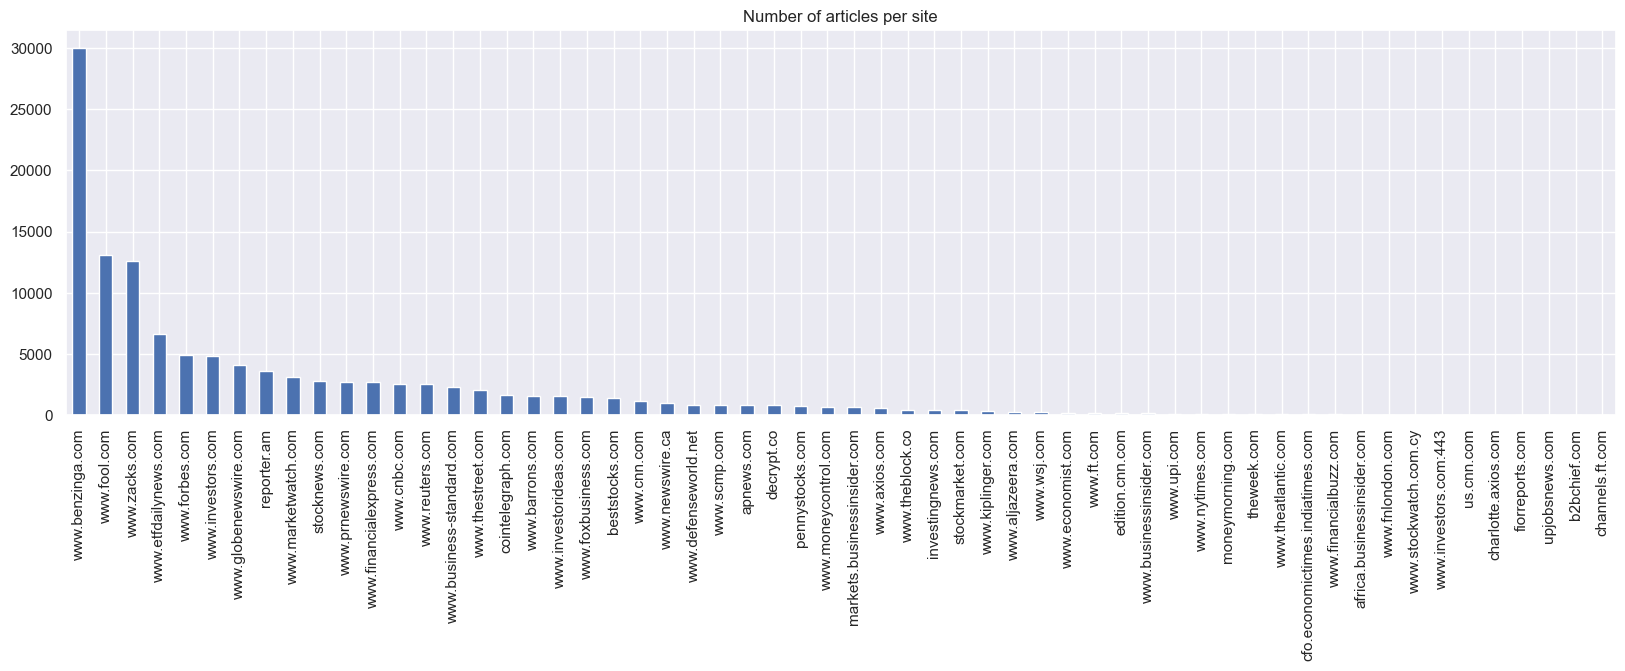

In [25]:
# create a histogram of the site column
sent_df['site'].value_counts().plot(kind='bar', figsize=(20,5))
plt.title('Number of articles per site')

## Get daily financial data of all companies, going a quarter back

## Get all fundamental data of a company

Including:

* Overview
* Income Statement
* Balance Sheet
* Cash Flow
* Earnings
* Earnings Calender

### Add a histogram of the number of times each stock is mentioned

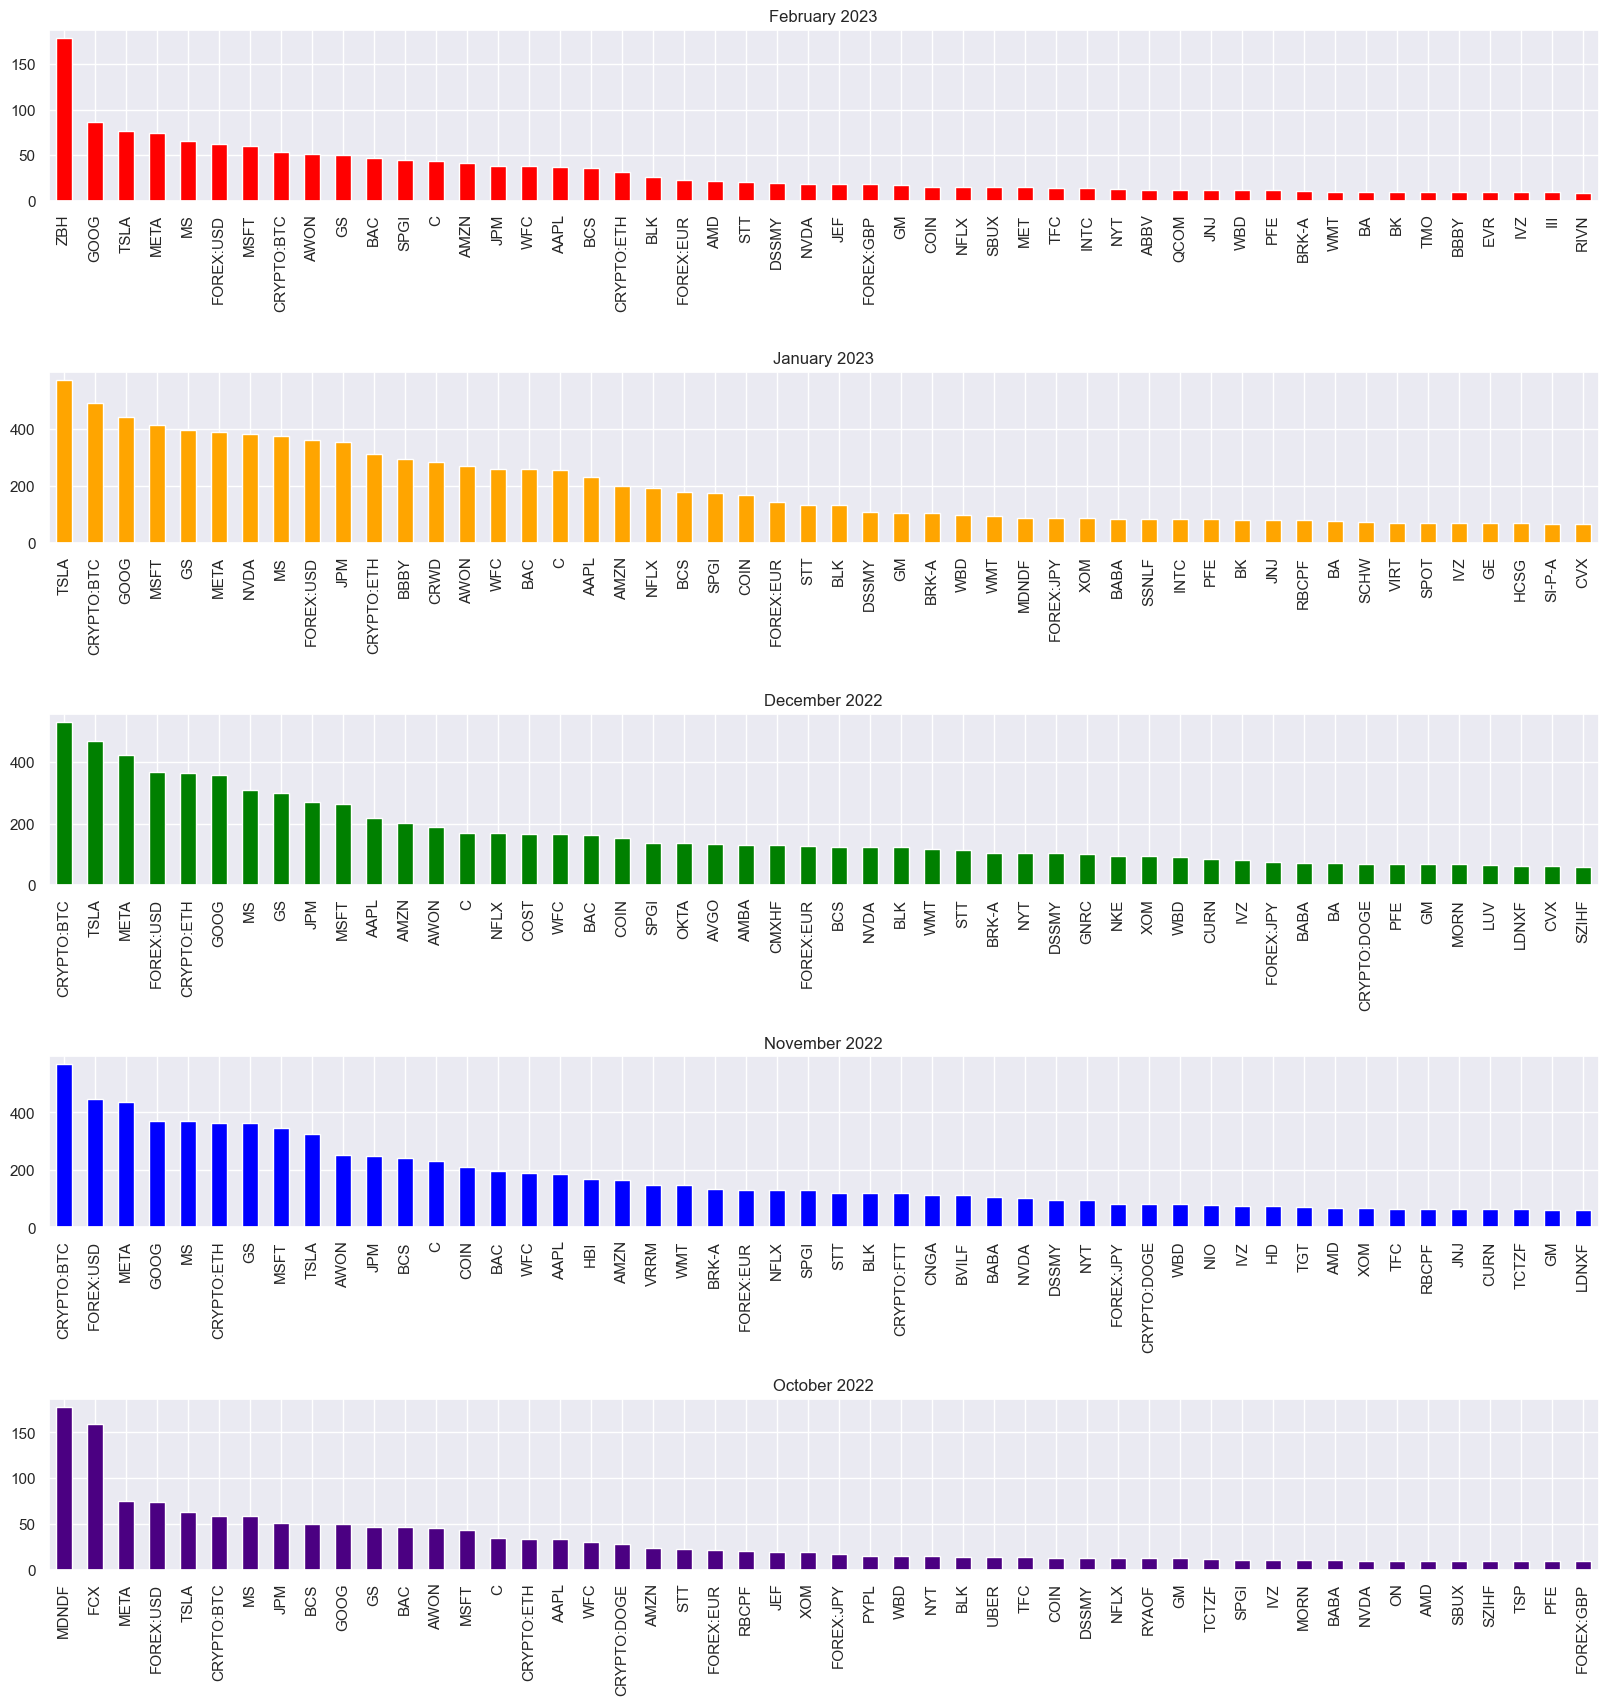

In [26]:
# plot a histogram of the number of times each ticker appears in the dataframe when grouped by month
# split the dataframe according to number of months before current month
sent_df['time'] = pd.to_datetime(sent_df['time']).dt.date
sent_df['month'] = pd.to_datetime(sent_df['time']).dt.month
sent_df['year'] = pd.to_datetime(sent_df['time']).dt.year
fig, axs = plt.subplots(len(sent_df['month'].unique()), figsize=(20, 20))
# create a list of 12 colors to use for the 12 months
colors = ['red', 'orange', 'green', 'blue', 'indigo', 'violet', 'brown', 'pink', 'gray', 'black', 'white', 'yellow']
plt.subplots_adjust(hspace=1)
for i, month in enumerate(sent_df['month'].unique()):
    # plot the top 50 tickers for each month
    sent_df[sent_df['month'] == month]['ticker'].value_counts().head(50).plot(kind='bar', ax=axs[i], label=month, color=colors[i])
    # convert month from number to name, by using 
    axs[i].set_title(calendar.month_name[month] + ' ' + str(sent_df[sent_df['month'] == month]['year'].unique()[0]))
# remove the month column when youre done
sent_df.drop(columns=['month', 'year'], inplace=True)
# save the figure
plt.savefig('stock_mentions_by_month.png')

## Basic analysis
Take MDNDF stock (mcdonalds japan).

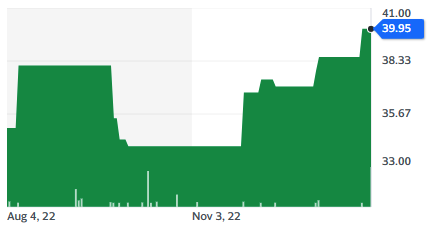

In [36]:
# load a png image
from PIL import Image
Image.open('Screenshot 2023-02-05 211157.png')

This stock crashed in late September by 20% and almost returned to its original price by December. It was highly mentioned in late October, so wed like to see whether the positive sentiments kept on flowing in November

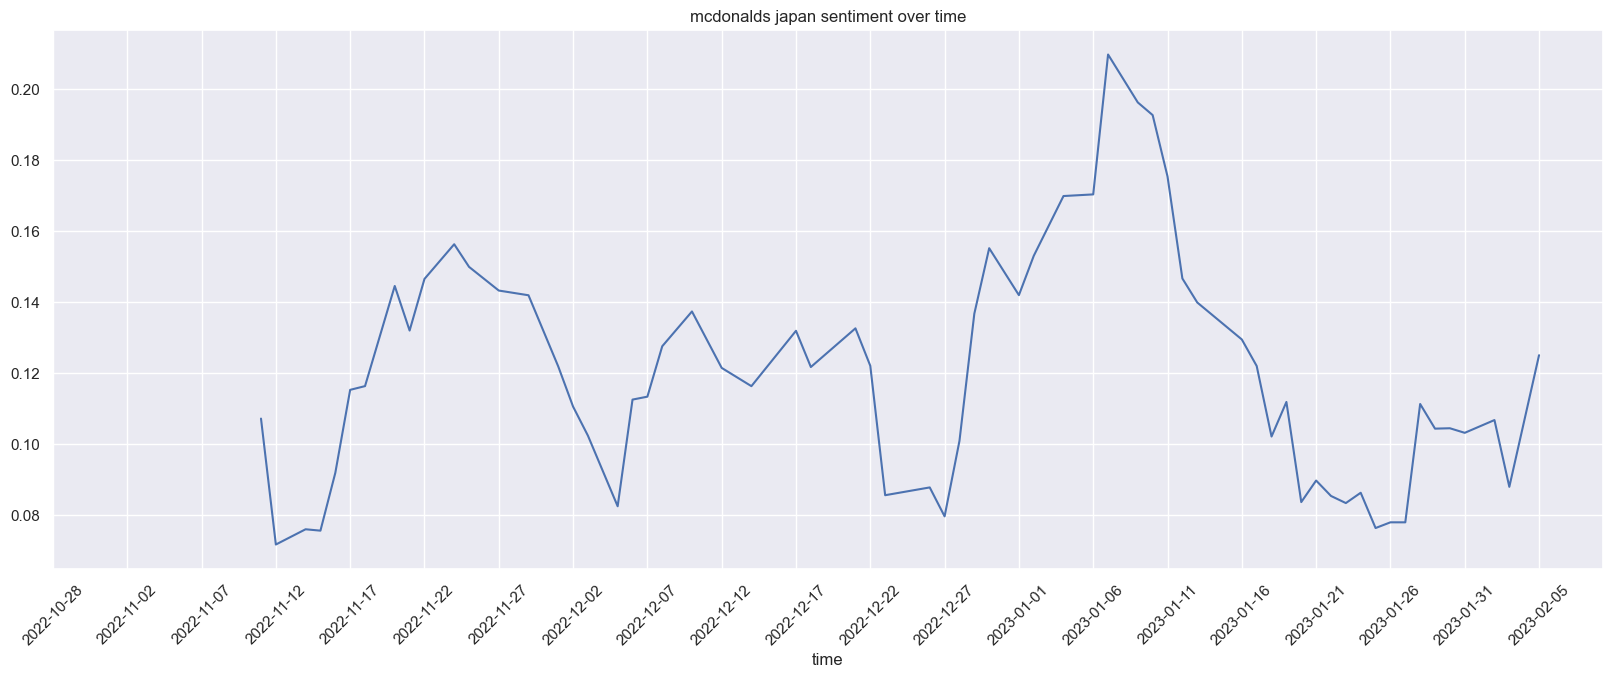

In [27]:
# do the same but average over every 10 days with ticks every 10 days
sent_df[sent_df['ticker'] == 'MDNDF'].groupby('time')['sentiment'].mean().rolling(10).mean().plot(figsize=(20,7), label='MDNDF')
# add the same ticks for every 10 days
plt.xticks(pd.date_range(sent_df['time'].min(), sent_df['time'].max(), freq='5D'), rotation=45)
plt.title('mcdonalds japan sentiment over time')
plt.savefig('mdndf_analysis.png')

As suspected, the news sentiments suggested to buy in november. Then, by the end of December suggested to sell, and in January suggested to buy again.

### <span style="color:green"> This means we could choose one of two approaches: </span>

1. Scan for any stocks that are being highly active in the news space, then see if they are at a monthly low and have a positive mean sentiment we can buy (or short if the opposite case)
2. Scan for any stocks that are traded in a suspiciously large volume, and check the overall mean sentiment suggested by the news sources (this will be proven in the daily stock data scraping)
